In [1]:
import Model
import Load
import functions as func

import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import eig
from scipy.integrate import solve_ivp


In [2]:
#### Domain parameters
global seaside, roof, top, wall, tip
seaside = 10  # Length of the domain in x-direction
roof = 13  # Length of the domain in y-direction (roof of the crownwall)
top = 10 # top of the caisson
wall = 8 # location of the left side of the crownwall
tip = 1 # tip of the crownwall

#### Mesh generation
global points, triangles, group_bottom, group_sea, bottom_edges, sea_edges

# Mesh size
lc_big = 2
lc_small = 0.5

interior_tag, sea_side_tag, bottom_side_tag = Model.Mesh(lc_small, lc_big, seaside, roof, top, wall, tip)
points, triangles, group_bottom, group_sea, bottom_edges, sea_edges, mesh = Model.form_mesh(bottom_side_tag, sea_side_tag)

# Mesh parameters
E = 36e9  # Young's modulus in Pa
nu = 0.3  # Poisson's ratio
k_bottom = -5000 * 10**3 # Bottom stiffness in N/m^3
density = 2500  # Density in kg/m^3
body_force = np.array([0, -9.81 * density])  # Body force (gravity)
# body_force = np.array([0, 0])  # Body force (gravity)
C = func.elasticity_tensor(E, nu)

K, M, f = Model.BC_modal(mesh, triangles, points, C, density, body_force, bottom_edges, sea_edges, k_bottom, roof)

#### Load parameters
global H, h, beta, k, h_tot, d, h1, h2
h = 10 # water depth [m]
beta = 2
k = 2 * np.pi / 10  # wave number, assuming a wavelength of 10 m

# Load parameters
H = 1
h_tot = 13 # m
eta = 5 #surface elevation [m] (time dependent)

d = 10 
h1 = h
h2 = 11 # height to start of curvature

In [3]:
# Modal analysis parameters
tspan = np.linspace(0, 5, 480)
t_rwt, eta_rwt = np.loadtxt('wavetrain.txt', skiprows=1, dtype=float, delimiter=',').T
f0 = 0.1

In [4]:
# define degrees of freedom
bottom_Bnodes = np.where(np.isin(points[:, 1], points[bottom_edges[:, 1], 0]))[0]
sea_Bnodes = np.where(np.isin(points[:, 0], points[sea_edges[:, 0], 0]))[0]
sea_Bnodes = [int(x) for x in sea_Bnodes if x not in bottom_Bnodes] 

Bdof_x = []
Bdof_y = []
Sdof_x = []
Sdof_y = []

for node in bottom_Bnodes:
    dof_x = 2 * node
    dof_y = 2 * node + 1
    Bdof_x.append(dof_x)
    Bdof_y.append(dof_y)

for node in sea_Bnodes:
    dof_x = 2 * node
    dof_y = 2 * node + 1
    Sdof_x.append(dof_x)
    Sdof_y.append(dof_y)

for tri in triangles:
    # For each triangle, get the degrees of freedom
    # Each triangle has 3 nodes, each node has 2 DOFs (x and y)
    # So we have 6 DOFs per triangle
    dofs = np.array([[2*tr, 2*tr+1] for tr in tri]).flatten()

n_dofs = len(points) * 2

#separating free and fixed dofs
DoFP = np.array(Bdof_x) #Fixed dofs
DoFF = np.arange(0, n_dofs) #free dofs
DoFF = np.delete(DoFF, DoFP) #remove fixed dofs from free dofs

fx = DoFF[:, np.newaxis]
fy = DoFF[np.newaxis, :]
bx = DoFP[:, np.newaxis]
by = DoFP[np.newaxis, :]

M_FF = M[fx, fy] # M containing only free dofs
K_FF = K[fx, fy] # K containing only free dofs

M_PP = M[bx, by] # M containing only fixed dofs
K_PP = K[bx, by] # K containing only fixed dofs

M_FP = M[fx, by] 
K_FP = K[fx, by] 



In [5]:
mat = np.dot(np.linalg.inv(M_FF), K_FF)
omega2_vec, phi_vec = eig(mat)  # Use eigh for symmetric matrices
print("Eigenvalues (squared frequencies):", len(phi_vec))
# omega2_vec[np.where(omega2_vec < 0)] = -omega2_vec[np.where(omega2_vec < 0)]
omega_vec = np.sqrt(omega2_vec.real)  # Convert eigenvalues to angular frequencies

f_vec = omega_vec/2/np.pi
idx = np.argsort(f_vec)
phi_sor = phi_vec[:, idx]

modal_shapes = np.zeros((n_dofs, len(f_vec)))
# print("Modal shapes shape:", modal_shapes.shape)
modal_shapes[len(DoFP):, :] = phi_sor

# print(phi_sor)
# print(max(np.abs(modal_shapes[:,0][0::2])))

Eigenvalues (squared frequencies): 278


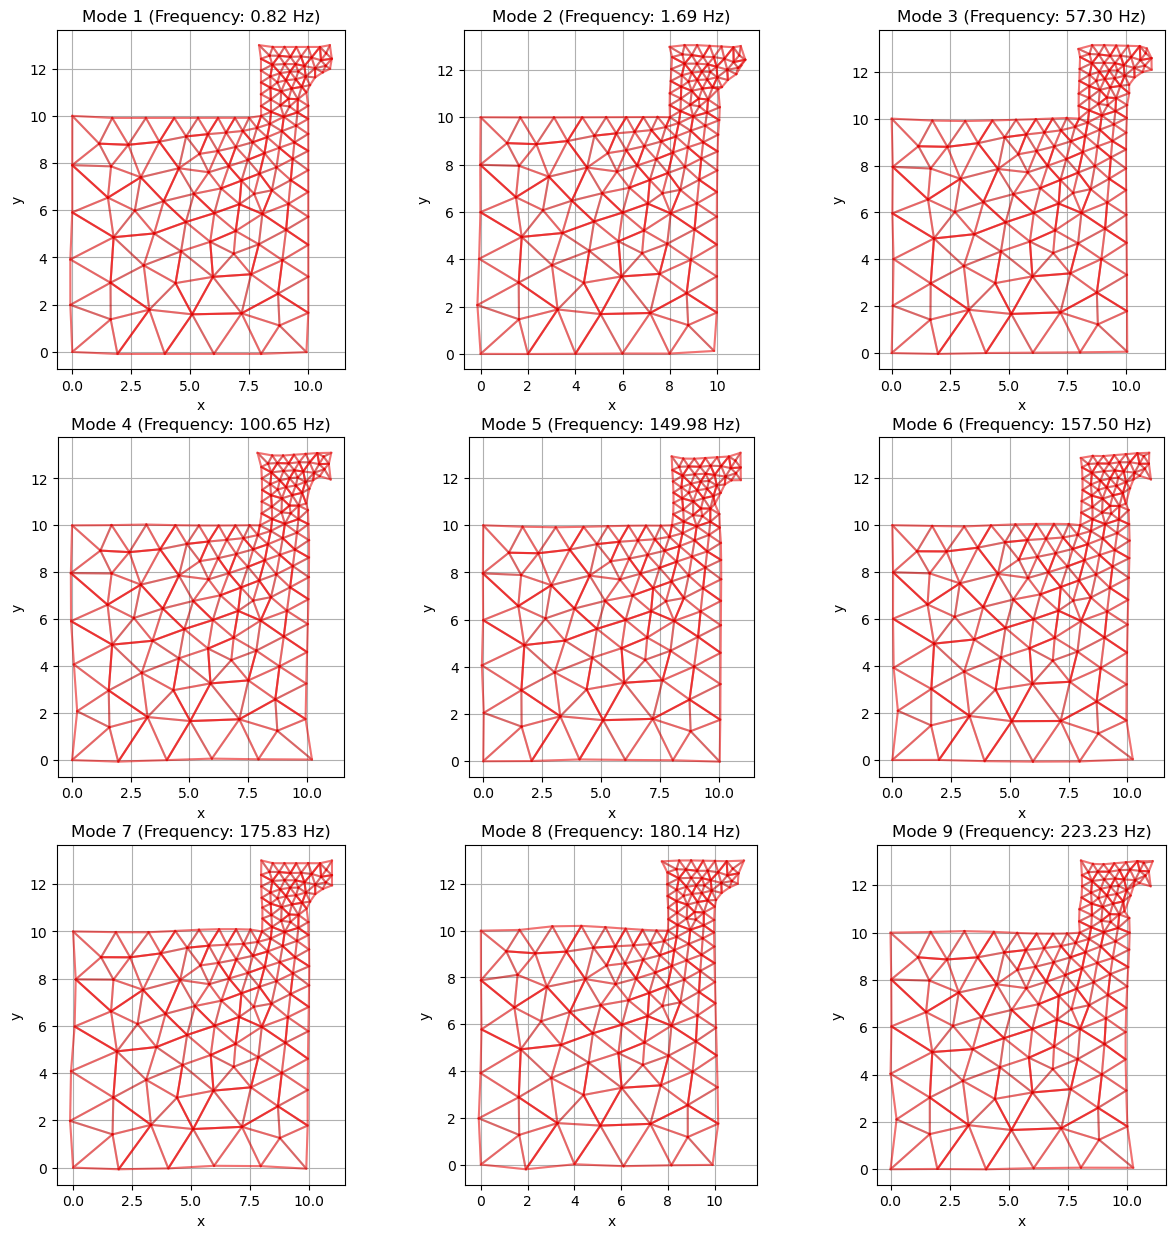

In [6]:
#plotting modal shapes
nmodes = 9
n_col = int(np.round(np.sqrt(nmodes)))
n_row = int(np.ceil(nmodes/n_col))
fig, ax = plt.subplots(n_row, n_col, figsize=(15, 15))
coords = points
n_tri = len(triangles)
for i in np.arange(1, nmodes + 1):
    shape = modal_shapes[:, i]

    maxtranslationx = np.max(np.abs(shape[0::2]))
    maxtranslationy = np.max(np.abs(shape[1::2]))
    # shape[0::2] = shape[0::2] / maxtranslationx * 1
    # shape[0::2] = shape[1::2] / maxtranslationy * 1

    coords_displaced_x = [c[0] for c in coords] + shape[0::2]
    coords_displaced_y = [c[1] for c in coords] + shape[1::2]
    coords_displaced = (coords_displaced_x, coords_displaced_y)
    row = (i - 1) // n_col
    col = (i - 1) % n_col
    for j in np.arange(0, n_tri):
        tri = triangles[j]
        coords_tri = np.array([coords_displaced[0][tri], coords_displaced[1][tri]]).T
        coords_tri = np.vstack((coords_tri, coords_tri[0]))
        ax[row, col].plot(coords_tri[:, 0], coords_tri[:, 1], 'k-', alpha=0.1)
        ax[row, col].plot(coords_displaced[0][tri], coords_displaced[1][tri], 'r-', alpha=0.5)
    ax[row, col].set_title(f"Mode {i} (Frequency: {f_vec[idx[i-1]]:.2f} Hz)")
    ax[row, col].set_aspect('equal')
    ax[row, col].set_xlabel("x")
    ax[row, col].set_ylabel("y")
    ax[row, col].grid(True)

In [7]:
PHI = phi_sor[:, 0:nmodes]
Mm = np.zeros(nmodes)
Km = np.zeros(nmodes)
Cm = np.zeros(nmodes)

xi = 0.001 # Modal damping ratio

for i in np.arange(0, nmodes):
    Mm[i] = -(PHI[:,i].T @ M_FF @ PHI[:, i])
    Km[i] = -(PHI[:,i].T @ K_FF @ PHI[:, i])
    Cm[i] = 2 * xi * np.sqrt(Mm[i] * Km[i])

    # Mm[i] = -Mm[i]
    # Km[i] = -Km[i]

    print(f"Mode {i+1}: Mass = {Mm[i]:.2f}, Stiffness = {Km[i]:.2f}m, Damping = {Cm[i]:.2f}")

Mode 1: Mass = 960.05, Stiffness = 25481.41m, Damping = 9.89
Mode 2: Mass = 1940.77, Stiffness = 217589.85m, Damping = 41.10
Mode 3: Mass = 357.87, Stiffness = 46382159.49m, Damping = 257.67
Mode 4: Mass = 1027.31, Stiffness = 410886781.72m, Damping = 1299.40
Mode 5: Mass = 932.47, Stiffness = 828071758.77m, Damping = 1757.44
Mode 6: Mass = 896.95, Stiffness = 878403691.09m, Damping = 1775.26
Mode 7: Mass = 761.41, Stiffness = 929271040.50m, Damping = 1682.33
Mode 8: Mass = 1239.21, Stiffness = 1587594168.27m, Damping = 2805.26
Mode 9: Mass = 2810.88, Stiffness = 5529788814.36m, Damping = 7885.07


In [8]:
# Defining wave load
def force(t, t_rwt, eta_rwt, f, sea_dofs_x, printing=False):
    """""
    define the force on the crownwall based on surface elevation at time t using the modified Goda method for recurve crown walls.
    Parameters:
    t (float): Time at which to calculate the force.
    t_rwt (array): Time array for the wave train.
    eta_rwt (array): Surface elevation array for the wave train.
    f (array): Array to store the calculated forces along the depth of the caisson.
    sea_dofs_x (list): List of horizontal degrees of freedom corresponding to the seaside nodes.
    """""
    eta = np.interp(t, t_rwt, eta_rwt)
    goda = Load.goda_original(d, beta, H, eta, k) # define goda parameters
    q_goda = Load.array_Goda(h_tot, h1, h2, eta, goda, k, H) #define force distribution along the depth of the breakwater

    n_fp = 1000 # Number of points for interpolation
    z = np.linspace(0, roof, n_fp)  # Length of the breakwater
    q = -np.array(q_goda)

    # Interpolate the force distribution along the depth of the breakwater
    idx_coords = [int(dof / 2) for dof in sea_dofs_x]  # Convert to indices for points
    z_coords = points[idx_coords][:, 1]  # Extract z-coordinates of the seaside nodes

    q_interp = np.interp(z_coords, z, q)

    # Plotting for debugging
    if printing == True:
        plt.plot(z, q, label='Force over length')
        plt.plot(z_coords, q_interp, 'ro', label='Interpolated Force')
    dz = z_coords[1] - z_coords[0]

    for dof in sea_dofs_x:
        z_coord = points[int(dof / 2), 1]
        i = np.where(z_coords == z_coord)[0]
        q_comp = q_interp[i]
        F_comp = q_comp * dz
        f[dof] = F_comp[0] 
    return f

In [9]:
def F(t):
    return -PHI.T @ force(t, t_rwt, eta_rwt, f, Sdof_x)[DoFF]

In [10]:
def qdot(t, q):
    u_m = q[0:nmodes]
    v_m = q[nmodes: 2*nmodes]
    a_m = ( F(t) - (Km * u_m + Cm * v_m)) / Mm
    return np.append(v_m, a_m)

In [11]:
q0 = np.zeros(2*nmodes)
q = solve_ivp(fun=qdot,y0=q0,t_span=[tspan[0], tspan[-1]], t_eval=tspan)

Text(0.5, 1.0, 'FEM results from modal analysis')

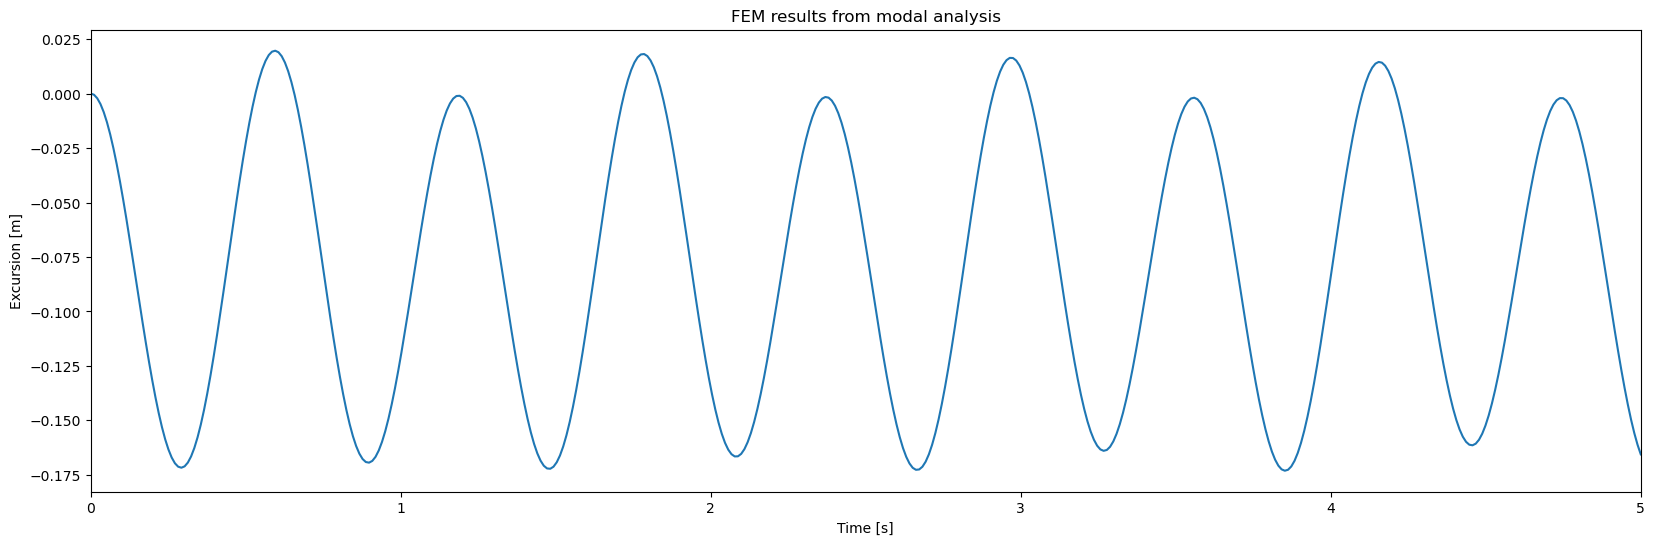

In [12]:
U_F = np.zeros((len(q.t),len(PHI[:,0])))
for i in np.arange(0,nmodes):
    for it in np.arange(0,len(q.t)):
        U_F[it,:] += PHI[:,i] * q.y[i][it]

plt.figure(figsize=(20, 6))        
plt.plot(tspan, U_F[:,len(PHI[:,0])-len(DoFF)], label='FEM results')
plt.xlabel("Time [s]")
plt.xlim([0, 5])
plt.ylabel("Excursion [m]")
plt.title("FEM results from modal analysis")